In [1]:
!git clone https://github.com/shobhitsundriyal/Track_Data.git

Cloning into 'Track_Data'...
remote: Enumerating objects: 15720, done.
remote: Counting objects: 100% (15720/15720), done.
remote: Compressing objects: 100% (15719/15719), done.
remote: Total 15720 (delta 0), reused 15720 (delta 0), pack-reused 0
Receiving objects: 100% (15720/15720), 196.37 MiB | 15.39 MiB/s, done.
Checking out files: 100% (15749/15749), done.


In [2]:
!ls Track_Data

driving_log.csv  IMG  readme.md


In [0]:
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.optimizers import Adam
import cv2
import pandas as pd
import ntpath
import matplotlib.image as mpimg
import random

In [18]:
datadir = 'Track_Data'
coloums = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'), names=coloums)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,Z:\Zself driving car data\IMG\center_2018_09_20_23_54_44_259.jpg,Z:\Zself driving car data\IMG\left_2018_09_20_23_54_44_259.jpg,Z:\Zself driving car data\IMG\right_2018_09_20_23_54_44_259.jpg,0.0,0.0,0,1.271747
1,Z:\Zself driving car data\IMG\center_2018_09_20_23_54_44_359.jpg,Z:\Zself driving car data\IMG\left_2018_09_20_23_54_44_359.jpg,Z:\Zself driving car data\IMG\right_2018_09_20_23_54_44_359.jpg,0.0,0.0,0,1.258977
2,Z:\Zself driving car data\IMG\center_2018_09_20_23_54_44_461.jpg,Z:\Zself driving car data\IMG\left_2018_09_20_23_54_44_461.jpg,Z:\Zself driving car data\IMG\right_2018_09_20_23_54_44_461.jpg,0.0,0.0,0,1.246335
3,Z:\Zself driving car data\IMG\center_2018_09_20_23_54_44_563.jpg,Z:\Zself driving car data\IMG\left_2018_09_20_23_54_44_563.jpg,Z:\Zself driving car data\IMG\right_2018_09_20_23_54_44_563.jpg,0.0,0.0,0,1.233820
4,Z:\Zself driving car data\IMG\center_2018_09_20_23_54_44_663.jpg,Z:\Zself driving car data\IMG\left_2018_09_20_23_54_44_663.jpg,Z:\Zself driving car data\IMG\right_2018_09_20_23_54_44_663.jpg,0.0,0.0,0,1.221436


In [19]:
def path_split(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_split)
data['right'] = data['right'].apply(path_split)
data['left'] = data['left'].apply(path_split)
  
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_09_20_23_54_44_259.jpg,left_2018_09_20_23_54_44_259.jpg,right_2018_09_20_23_54_44_259.jpg,0.0,0.0,0,1.271747
1,center_2018_09_20_23_54_44_359.jpg,left_2018_09_20_23_54_44_359.jpg,right_2018_09_20_23_54_44_359.jpg,0.0,0.0,0,1.258977
2,center_2018_09_20_23_54_44_461.jpg,left_2018_09_20_23_54_44_461.jpg,right_2018_09_20_23_54_44_461.jpg,0.0,0.0,0,1.246335
3,center_2018_09_20_23_54_44_563.jpg,left_2018_09_20_23_54_44_563.jpg,right_2018_09_20_23_54_44_563.jpg,0.0,0.0,0,1.233820
4,center_2018_09_20_23_54_44_663.jpg,left_2018_09_20_23_54_44_663.jpg,right_2018_09_20_23_54_44_663.jpg,0.0,0.0,0,1.221436


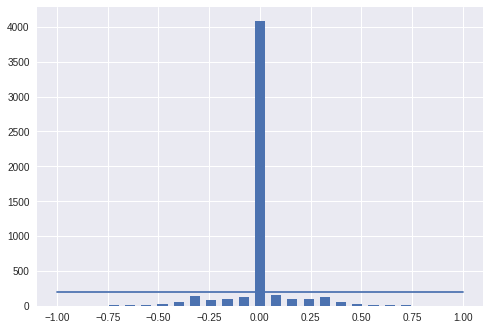

In [20]:
n_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], n_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin, samples_per_bin))

total data: 5249
removed: 3884
remaining: 1365


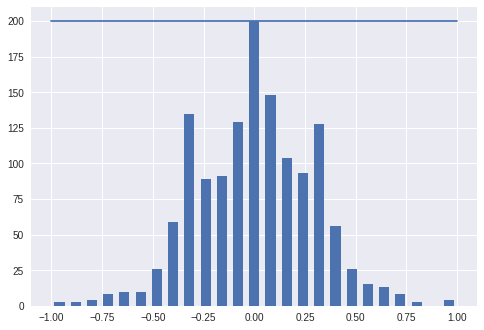

In [21]:
print('total data:', len(data))
remove_list = []
for j in range(n_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (n_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [23]:
print(data.iloc[1])

center      center_2018_09_20_23_54_46_288.jpg
left        left_2018_09_20_23_54_46_288.jpg  
right       right_2018_09_20_23_54_46_288.jpg 
steering   -0.608811                          
throttle    1                                 
reverse     0                                 
speed       4.59064                           
Name: 20, dtype: object


In [0]:
def load_img(datadir, df):
  image_path = []
  steering =[]
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center , left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steering

image_paths, steering = load_img(datadir + '/IMG', data)

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steering, test_size=0.2)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1092
Valid Samples: 273


Text(0.5,1,'Validation set')

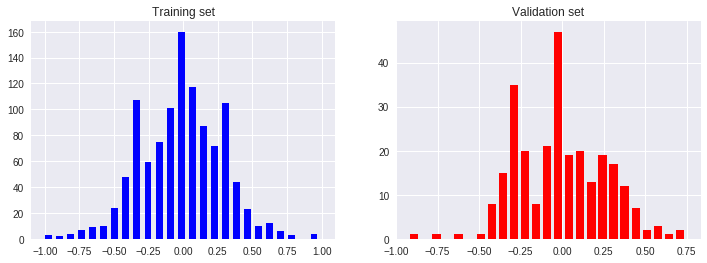

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=n_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=n_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [0]:
def img_preprocess(img):#img is a path
  img = mpimg.imread(img)
  img = img[60:135,: ,:]
  img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)#accoring to nvidia this color conversion is best for nvidia model
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200,66))#matches the size of nvidia model architecture
  img = img/255 
  return img

Text(0.5,1,'Preprocessed Image')

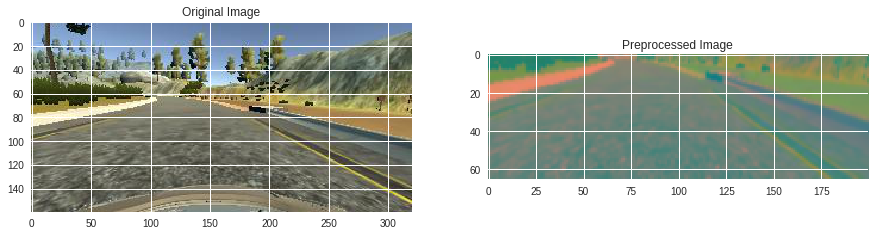

In [51]:
image = image_paths[10]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')


In [0]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(1092, 66, 200, 3)


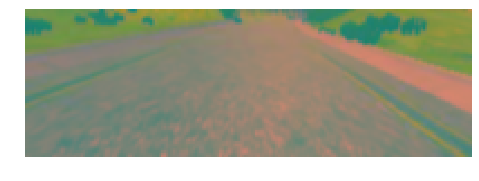

In [54]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [0]:
def nvidia_model():#relu had very bad training now using elu
  model = Sequential()
  model.add(Convolution2D(24, 5,5, subsample=(2,2), input_shape=(66,200,3), activation='elu'))
  model.add(Convolution2D(36, 5,5, subsample=(2,2), activation='elu'))
  model.add(Convolution2D(48, 5,5, subsample=(2,2), activation='elu'))
  model.add(Convolution2D(64, 3,3, activation='elu'))
  model.add(Convolution2D(64, 3,3, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  optimizer = Adam(lr=0.001)
  model.compile(loss='mse', optimizer=optimizer)
  
  return model


In [72]:
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)              0         
__________

In [73]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Train on 1092 samples, validate on 273 samples
Epoch 1/30
1092/1092 [==============================] - 2s 2ms/step - loss: 0.7570 - val_loss: 0.0964
Epoch 2/30
1092/1092 [==============================] - 1s 743us/step - loss: 0.1751 - val_loss: 0.0667
Epoch 3/30
1092/1092 [==============================] - 1s 720us/step - loss: 0.1221 - val_loss: 0.0636
Epoch 4/30
1092/1092 [==============================] - 1s 693us/step - loss: 0.1171 - val_loss: 0.0561
Epoch 5/30
1092/1092 [==============================] - 1s 690us/step - loss: 0.0968 - val_loss: 0.0542
Epoch 6/30
1092/1092 [==============================] - 1s 684us/step - loss: 0.0940 - val_loss: 0.0520
Epoch 7/30
1092/1092 [==============================] - 1s 680us/step - loss: 0.0895 - val_loss: 0.0511
Epoch 8/30
1092/1092 [==============================] - 1s 679us/step - loss: 0.0829 - val_loss: 0.0491
Epoch 9/30
1092/1092 [==============================] - 1s 686us/step - loss: 0.0839 - val_loss: 0.0466
Epoch 10/30
1092/10

Text(0.5,0,'Epoch')

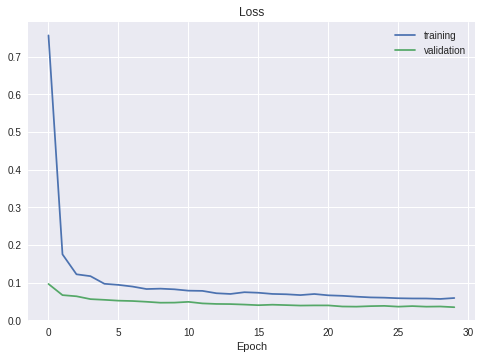

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')

In [90]:
!ls 'gdrive/My Drive'

Colab Notebooks		    kaggle.json   Motio Mota xoursera.txt
goDapping recovery ke.gdoc  kmeans.ipynb  Neural network.ipynb
ibm cloud.gdoc		    know.gdoc	  unityforML07.gdoc


In [86]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [91]:
import shutil
src = 'model.h5'
dest = 'gdrive/My Drive/behaviour_cloning.h5'
shutil.copy(src, dest)

'gdrive/My Drive/behaviour_cloning.h5'